In [1]:
from IPython.display import Image

# High harmonic generation

* Exposing a gas of atoms to a high intensity laser pulse, typically in the infrared (IR) region, results in short
bursts of radition in the extreme ultraviolet (EUV) or soft X-ray region.
* Multiple-harmonic generation in rare gases at high laser intensity: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.39.5751

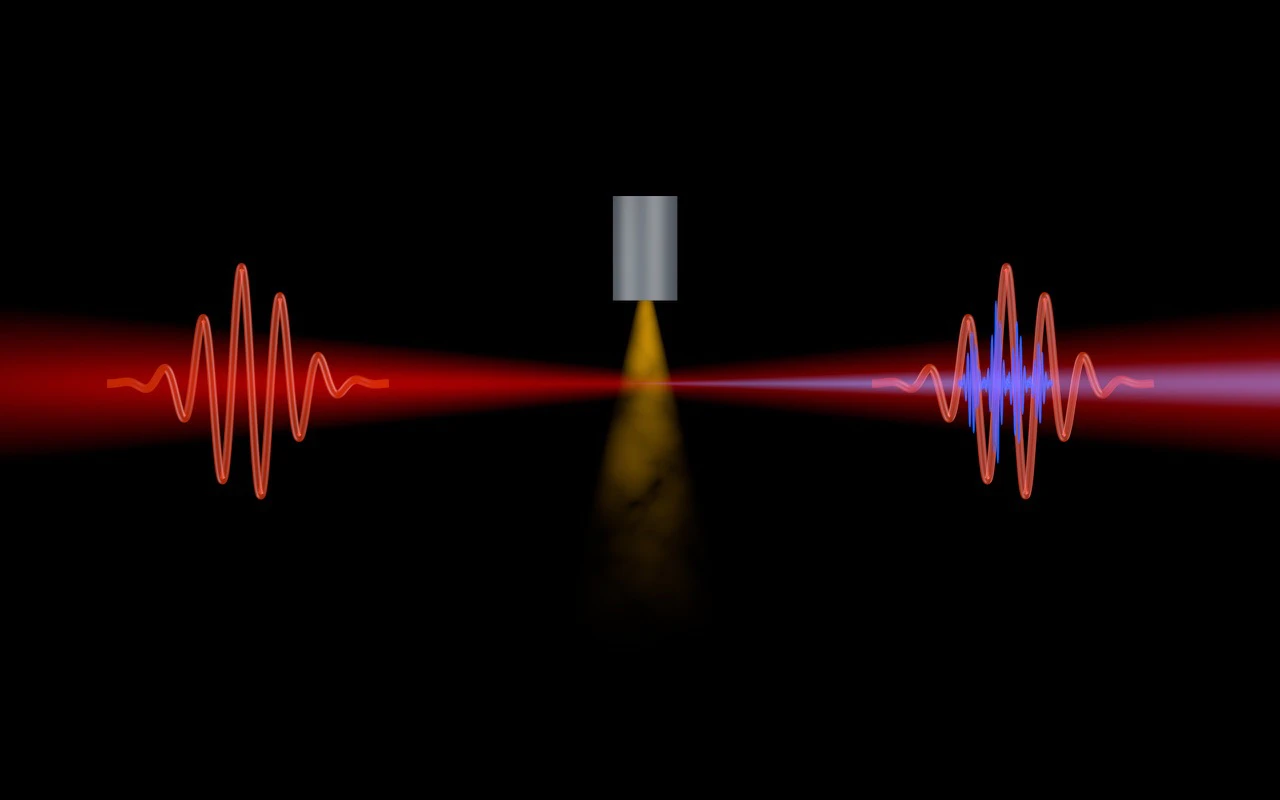

In [2]:
Image(filename='figures/hhg_gas_illustration.png', height=800, width=600)

* The radiation emitted in the HHG process are integer multiples of the laser frequency (referred to as the carrier-frequency) $\omega$

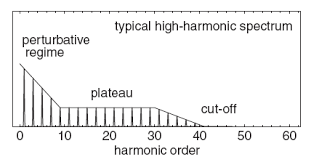

In [3]:
Image(filename='figures/hhg_spectrum.png', height=800, width=800)

## The three step model



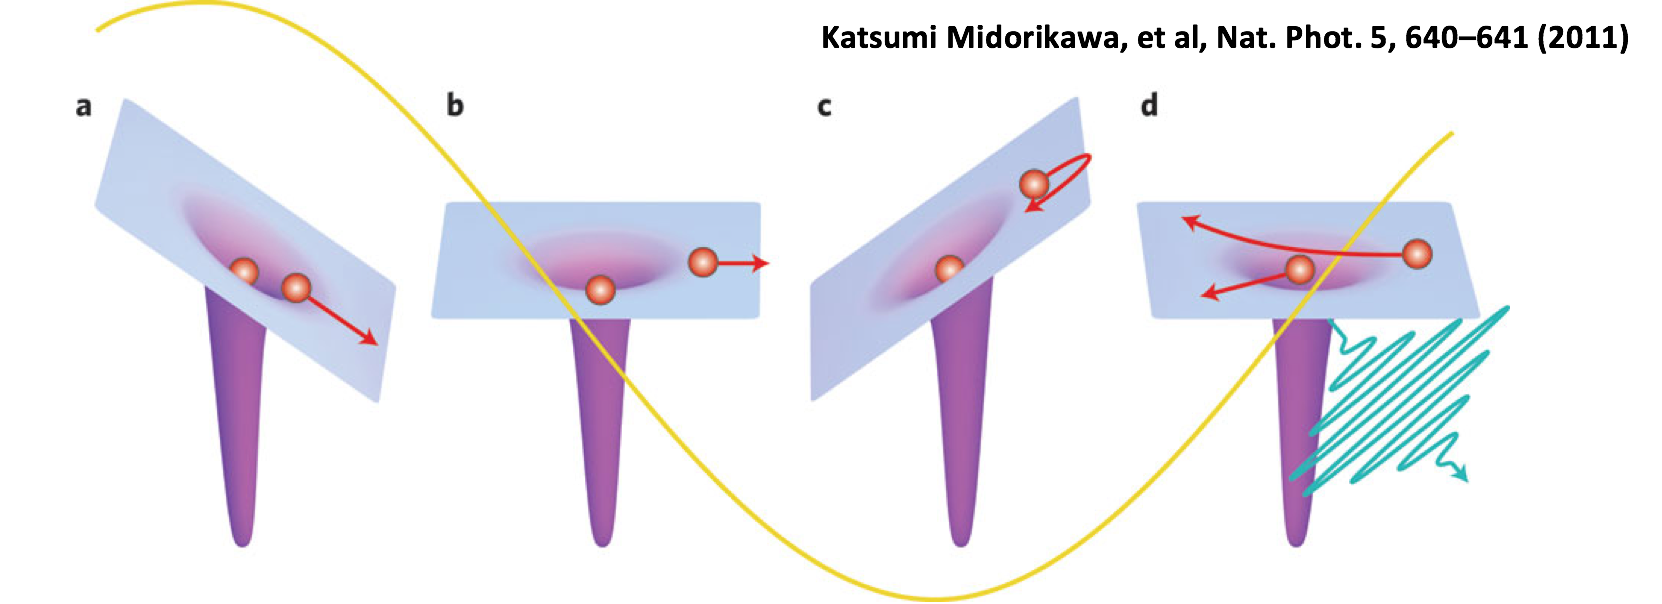

In [4]:
Image(filename='figures/High-Harmonic-Generation-EUV-Explained.png', height=800, width=800)

* (a) The electron tunnels out of the Coulomb potential  
* (b) The electron is accelerated in the field, gaining kinetic energy. As the field generated by the laser shifts direction, the electron accelerates back toward the atomic center.  
* (c,d) If the electron is re-absorbed into its parent ion; The kinetic energy of the returning electron is liberated as a high energy (low wavelength) photon (high harmonic or "overtone")  
* Source: https://www.kmlabs.com/blog/what-is-high-harmonic-generation
* HHG is one technique to produce attosecond pulses that can be used to probe electron dynamics 
* The Nobel prize in physics 2023 was awarded to Anne L'Hullier, Ferenc Krausz and Pierre Agostini "for experimental methods that generate attosecond pulses of light for the study of electron dynamics in matter" 
* https://www.nobelprize.org/prizes/physics/2023/popular-information/
* Attosecond physics review: https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.81.163
* Attosecond electron dynamics in molecules: https://doi.org/10.1021/acs.chemrev.6b00453
* Also noteworthy that Gerard Mourou and Donna Strickland recieved the Nobel prize in physics 2018 "for groundbreaking inventions in the field of laser physics", in particular "for their method of generating high-intensity, ultra-short optical pulses" 
* https://www.nobelprize.org/prizes/physics/2018/popular-information/

* We can simulate the HHG process with our 1D program
* A laser pulse can be modelled as a sine-wave modulated by an envelope function $f(t)$ $$E(t) = f(t) \sin (\omega t). $$ 
* A typical choice is the "sine-square" envelope 
$$ f(t) = \begin{cases} \sin^2\left(\frac{\pi t}{t_d} \right), \ \ 0 \leq t \leq t_d, \\ 0, \ \ \text{ else }, \end{cases} $$
where $t_d$ is the duration of the pulse.
* A one-dimensional Coulomb potential $$ V(x) = -\frac{Z}{\sqrt{(x-R)^2+a}}, $$
where $Z$ is the nuclear charge, $R$ the position of the nucleus and $a$ is a regularization parameter which is necessary since the $Z/|x|$-potential is divergent in 1D.

In [5]:
import numpy as np
from hamiltonian import Hamiltonian
from matplotlib import pyplot as plt
from potentials import *
from lasers import sine_square_laser, sine_laser
from cranknicolson import run_CN
from utils import compute_hhg_spectrum
from IPython.display import HTML
import matplotlib.animation as animation

Groundstate energy: -0.5004887739750282


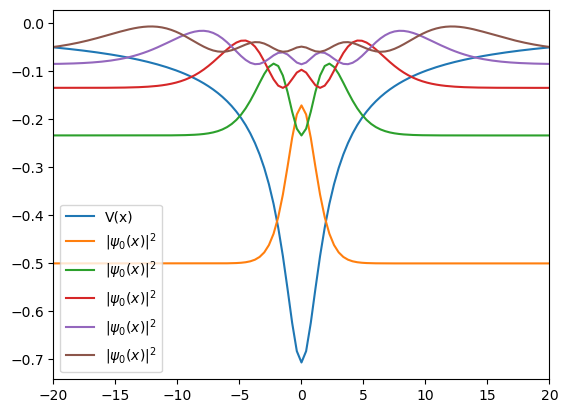

In [6]:
n_x = 801
x_max = 150
x = np.linspace(-x_max, x_max, n_x)
dx = x[1] - x[0]

hydrogen = Coulomb(x,Z=1,R=0,a=2)
n_eigenstates = 5

hamiltonian = Hamiltonian(x, hydrogen)
eps, psi = hamiltonian.get_eigenstates(n_eigenstates)
print(f"Groundstate energy: {eps[0]}")

plt.figure()
plt.plot(x, hydrogen, label=r'V(x)')
for k in range(psi.shape[1]):
    plt.plot(x, np.abs(psi[:,k])**2+eps[k], label=r'$|\psi_0(x)|^2$')
plt.legend()
plt.xlim(-20,20)
plt.show()

In [7]:
E0 = 0.03 #Electric field strength in atomic units (correspond to an intensity of ~ 5e13W/cm^2)
omega = 0.057 #Carrier frequency of the electric field (correspond to a wavelength of 800nm)

t_cycle = 2*np.pi/omega #
td = 3*t_cycle #Duration of the electric field

laser = sine_square_laser(E0, omega, td=td)
hamiltonian.set_electric_field(laser)

dt = 0.1
tfinal = td #Total simulation time
psi0 =  psi[:,0].copy()

Mask = np.vectorize(lambda x: 1 if x <= 0 else np.cos(x)**(0.25))
x_absorb = 120
mask = Mask( (abs(x)-x_absorb)/(x_max-x_absorb))

data = run_CN(hamiltonian, psi0, x, dt, tfinal, psi, mask=mask)

100%|███████████████████████████████████████| 3306/3306 [01:03<00:00, 51.71it/s]


* The HHG spectrum is proportional to Fourier transform of the expectation value $\langle x(t) \rangle$

Theory of high-harmonic generation by low-frequency laser fields: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.49.2117

On the dipole, velocity and acceleration forms in high-order harmonic generation from a single atom or molecule : https://iopscience.iop.org/article/10.1088/0953-4075/44/11/115601/meta

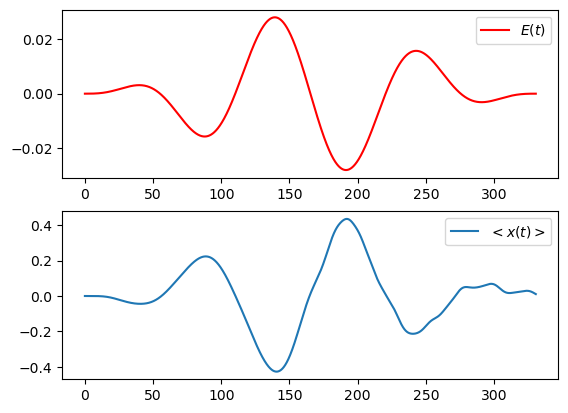

In [8]:
time_points = data["time_points"]
expec_x = data["expec_x"]
plt.figure()
plt.subplot(211)
plt.plot(time_points, laser(time_points), color='red', label=r'$E(t)$')
plt.legend()
plt.subplot(212)
plt.plot(time_points, expec_x.real, label=r'$<x(t)>$')
plt.legend()
plt.show()

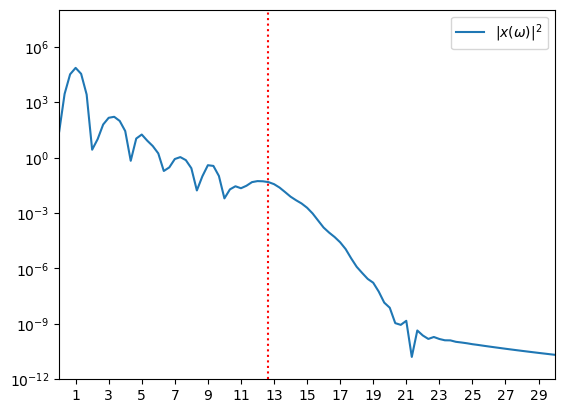

In [9]:
freq, x_omega = compute_hhg_spectrum(time_points, expec_x.real, hann_window=True)
Up = E0**2 / (4 * omega**2)
Ip = 0.5
Ecutoff = Ip + 3.17 * Up

plt.figure()
plt.semilogy(freq / omega, x_omega, label=r"$|x(\omega)|^2$")
plt.xlim(0,30)
plt.xticks(np.arange(1, 31, step=2))
plt.axvline(
    Ecutoff / omega, linestyle="dotted", color="red"
)
plt.legend()
plt.ylim(1e-12,1e8)
plt.show()

In [10]:
psi_hist = data["psi_hist"]
num_steps = len(time_points)

fig, ax = plt.subplots(figsize=(14, 8))
line, = ax.semilogy(x, np.abs(psi_hist[0])**2, label=r'$|\Psi(x,t)|^2$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    line.set_ydata(np.abs(psi_hist[25*frame])**2)
    time_text.set_text(f'Time: {25*frame*dt:.2f}')
    return line, time_text

ani = animation.FuncAnimation(fig, update, frames=num_steps//25, interval=100, blit=True)
# Set y limit to 0.5
ax.set_xlim(-150,150)
ax.set_ylim(1e-8, 0.5)
ax.legend()
# Save as mp4 file
# ani.save('animation.mp4', writer='ffmpeg')
html = HTML(ani.to_jshtml())
display(html)
plt.close() # update

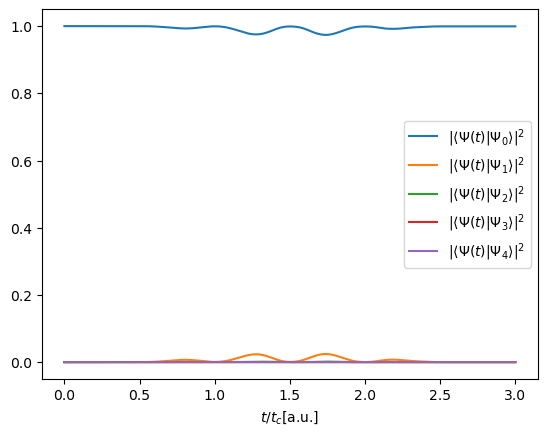

In [11]:
populations = data["populations"]
plt.figure()
for i in range(populations.shape[0]):
    plt.plot(time_points/t_cycle, np.abs(populations[i])**2, label=r"$|\langle \Psi(t)|\Psi_%d \rangle|^2$" % i)
plt.legend()
plt.xlabel(r'$t/t_c$[a.u.]')
plt.show()